In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import pickle
import cv2
import glob


In [2]:
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

In [3]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.

# the gray image color space has bad result with shadows, try 

def abs_sobel_thresh(gray_img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    grad_binary = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return grad_binary


# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(gray_img, sobel_kernel=3, thresh=(0, 255)):
    
    print("mag_thresh input:",thresh)

    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1
    
    
        
    # Return the binary image
    return mag_binary


def hsv_thresh(hsv_img, h_thresh=(0,180), s_thresh=(0,255), v_thresh=(0,255)):
    h_channel = hsv_img[:,:,0]
    s_channel = hsv_img[:,:,1]
    v_channel = hsv_img[:,:,2]

    
    # Threshold color channel
    o_binary = np.zeros_like(h_channel)
    o_binary[
        (h_channel >= h_thresh[0]) & (h_channel <= h_thresh[1]) &  \
        (s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1]) & \
        (v_channel >= v_thresh[0]) & (v_channel <= v_thresh[1]) \
              ] = 1
    
    return o_binary

# a larger kernel size make it smoother
def combined_thresh(hsv_img, ksize=31, magitude_thresh=(80, 255), dir_thresh=(0, np.pi/2), h_thresh=(0,180), s_thresh=(0,255), v_thresh=(0,255), subject=""):
    
    # for plotting purpose.
    
    one_channel = hsv_img[:,:,1]  # shape (640,480), S-channel

    
    # Define a kernel size for Gaussian smoothing / blurring
    # Kernel Must be an odd number (3, 5, 7...)
    #one_channel = gaussian_blur(one_channel, 19) 
        
    mag_binary = mag_thresh(one_channel, sobel_kernel=ksize, thresh=magitude_thresh)  
    mag_binary_blur = gaussian_blur(mag_binary, 13)
    
    plot_two_imgs(left_img=mag_binary, right_img=mag_binary_blur, left_cmap="gray", right_cmap="gray",  left_title="mag bin", right_title="mag bin blur")
    
    
    # apply color
    v_binary = hsv_thresh(hsv_img, h_thresh, s_thresh, v_thresh )
    
    v_binary_blur = gaussian_blur(v_binary, 33)

    plot_two_imgs(left_img=v_binary, right_img=v_binary_blur, left_cmap="gray", right_cmap="gray", left_title="v_binary", right_title="v_binary_blur")


    
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    # stacked_color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_with_color = np.zeros_like(mag_binary)
    combined_with_color[(v_binary_blur == 1) & (mag_binary_blur == 1)] = 1
    plot_two_imgs(left_img=hsv_img, right_img=combined_with_color,  left_title="hsv_img", right_title="combined_with_color")


    return combined_with_color

In [4]:
VIDEO_MODE = False
OUTPUT_IMG_DIR="./"

In [5]:
# plot input vs output side by side
# note that imshow expects rgb img

def plot_two_imgs(left_img, right_img, left_cmap=None, right_cmap=None, left_title = "left", right_title= "right", subject=""):
    if VIDEO_MODE:
        return
    
    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    if left_img is not None:
        ax1.imshow(left_img, cmap=left_cmap)
        ax1.set_title(subject+' '+left_title, fontsize=50)
    if right_img is not None:
        ax2.imshow(right_img, cmap=right_cmap)
        ax2.set_title(subject+' '+right_title, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [6]:
def rescale_frame(frame, width=640):
#    print(frame.shape[1],frame.shape[0])
    ratio = width * 1.0 / frame.shape[1]
    height = int(frame.shape[0] * ratio)
    dim = (width, height)
    
    return cv2.resize(frame, dim, interpolation =cv2.INTER_AREA)


def crop_binary_img(frame, r1=250, r2=470, c1=140, c2=500):
    
    cropped = np.zeros_like(frame)
    cropped[r1:r2, c1:c2] = frame[r1:r2, c1:c2] 
    
    return cropped
    

    


mag_thresh input: (80, 255)


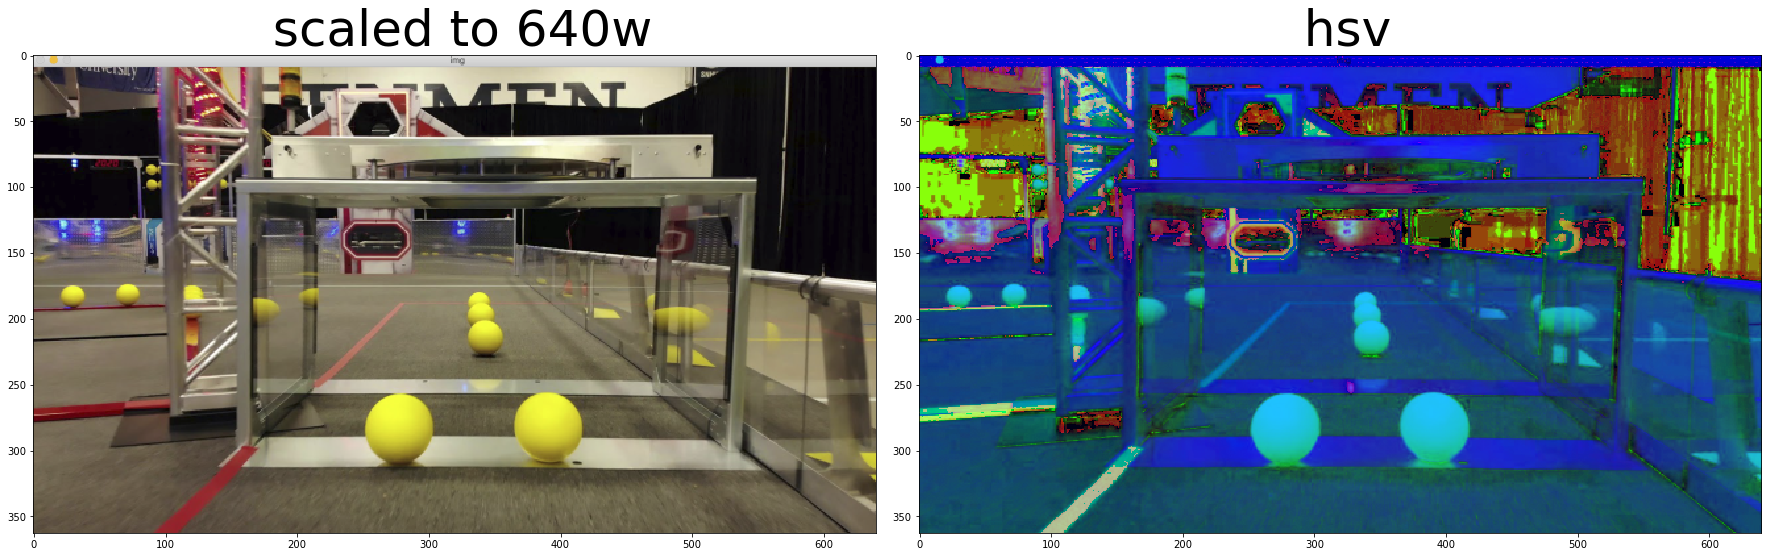

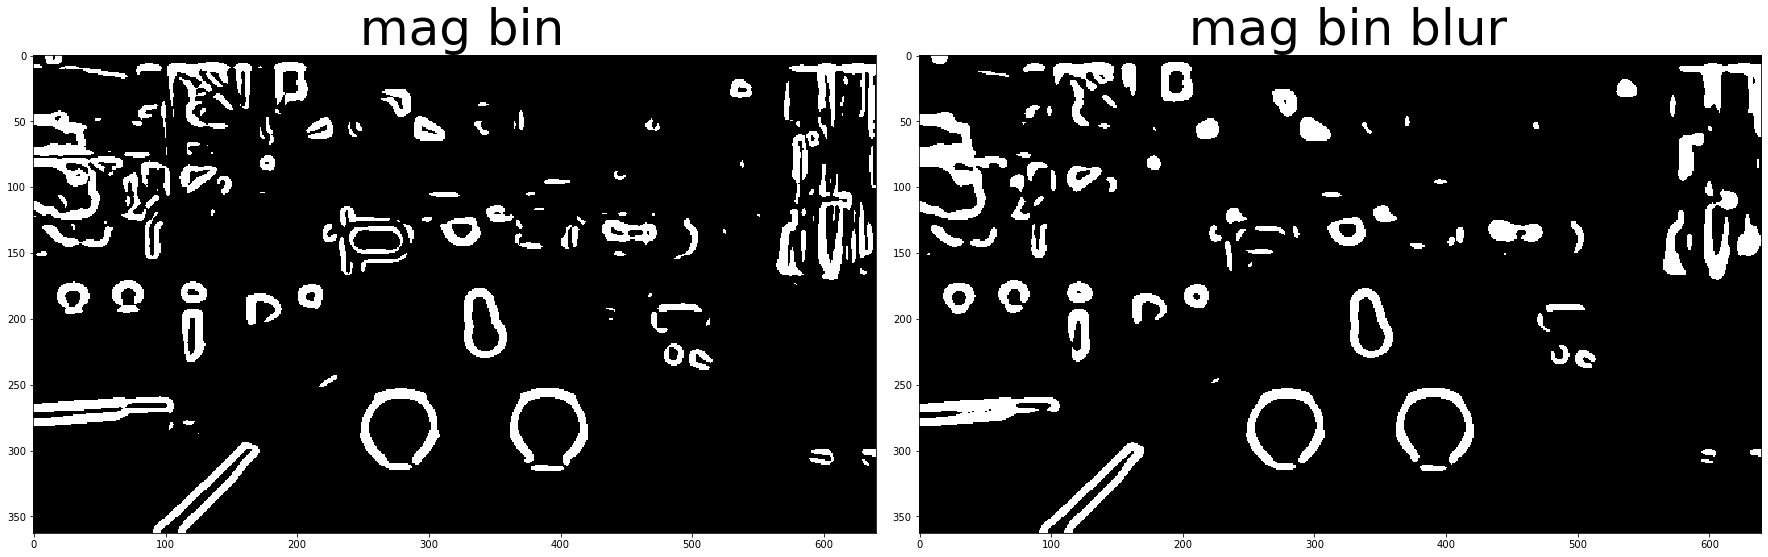

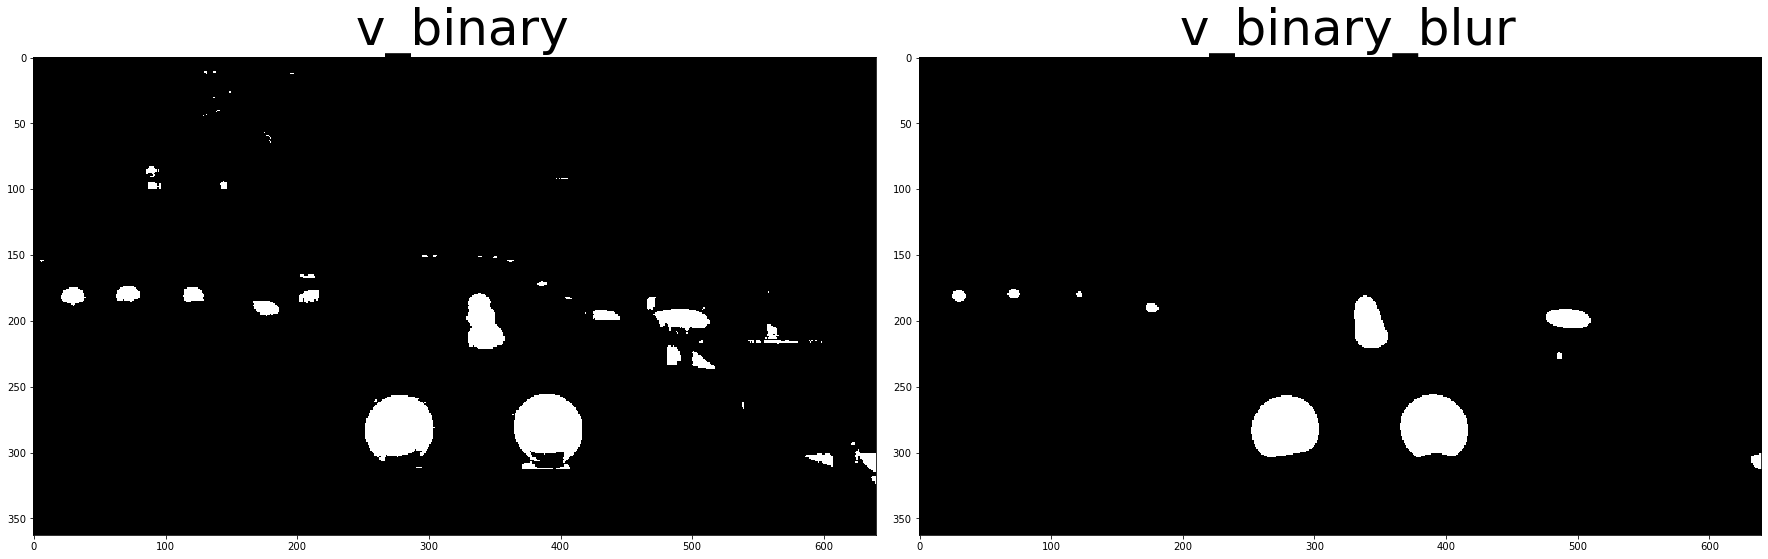

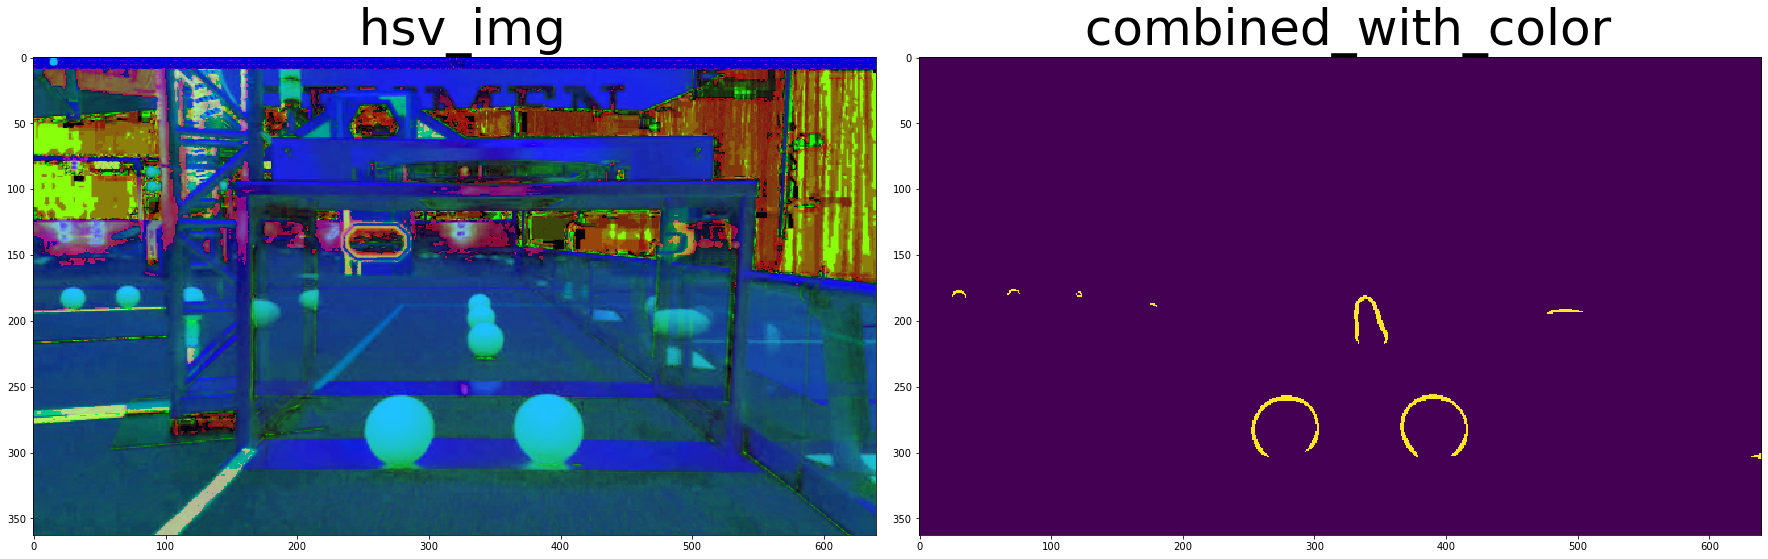

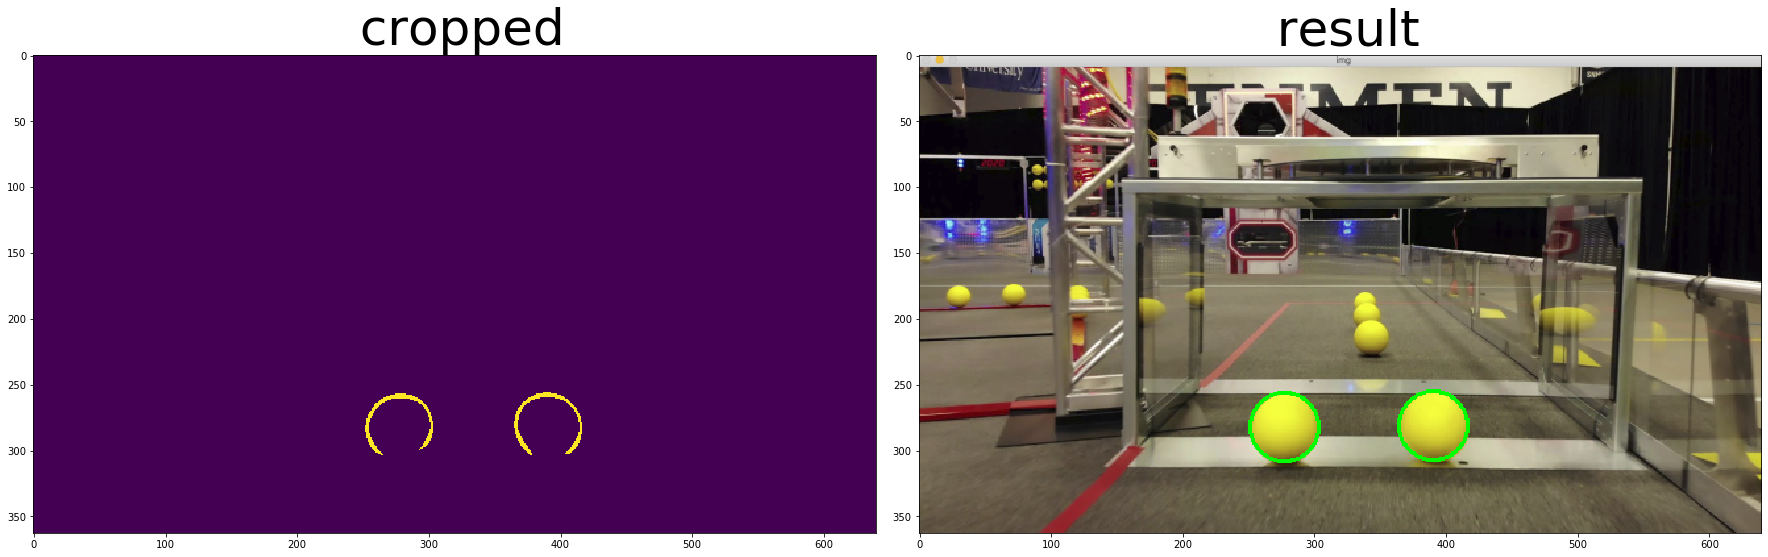

In [7]:
# TRY HSV here

#IMG_20200114_164420505.jpg
#IMG_20200114_193634939.jpg

rbg_img = cv2.imread('frc_ball.PNG')


smaller_rbg_img = rescale_frame(rbg_img)

hsv_img = cv2.cvtColor(smaller_rbg_img, cv2.COLOR_BGR2HSV)

plot_two_imgs(cv2.cvtColor(smaller_rbg_img, cv2.COLOR_BGR2RGB), hsv_img, left_title="scaled to 640w", right_title="hsv")


# 30 is hsv yellow
combined = combined_thresh(hsv_img, h_thresh=(26,34),s_thresh=(100, 255), v_thresh=(100,255))


cropped = crop_binary_img (combined)


# find contours in the binary image
contours,hierarchy = cv2.findContours(cropped,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

for cnt in contours:
    # approximate contour
    (x,y),radius = cv2.minEnclosingCircle(cnt)
    
    center = (int(x),int(y))
    radius = int(radius)
    cv2.circle(smaller_rbg_img,center,radius,(0,255,0),2)
    
    
plot_two_imgs(cropped, cv2.cvtColor(smaller_rbg_img,cv2.COLOR_BGR2RGB), left_title="cropped", right_title="result" )


In [8]:
# below is a tool to see how to find the right yellow is HSV space
#BGR
yellow = np.uint8([[[0,255,255 ]]]) 
hsv_yellow = cv2.cvtColor(yellow,cv2.COLOR_BGR2HSV)
print (hsv_yellow)


[[[ 30 255 255]]]
